In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import struct
import matplotlib.ticker as ticker
import wave  

np.set_printoptions(precision=4)
pd.set_option('precision', 4)

In [2]:
class Function:
    def __init__(self, start=None, end=None, step=None):
        if start is not None and end is not None and step is not None:
            self.initializeX(start, end, step)
            self.initializeY()
    
    def initializeX(self, start, end, step):
        self.start = start
        self.end = end
        self.step = step
        self.length = int(np.ceil(np.abs(end - start) / step))
        self.X = np.arange(start, end, step)
    
    def initializeY(self):
        self.Y = np.zeros(self.length)
        
    def lin(self, a, b):
        self.Y = a * self.X + b
    
    def exp(self, a, b):
        self.Y = np.exp(-a * self.X) * b
       
    def rand(self, scale):
        self.Y = np.array([random.uniform(-scale, scale) for _ in range(0, self.length)])
        
    def my_rand(self, scale):
        a = 45;
        c = -21;
        m = 100;
        seed = 0.4546;
        l = []
        for i in range(0, self.length):
            seed = (a * seed + c) % m
            l.append(seed)
        self.Y = np.array([(((l[i] - min(l)) / (max(l) - min(l))) * 2 - 1) * scale for i in range(0, len(l))])
        
    def sin(self, A, f):
        self.Y = A * np.sin(2 * np.pi * f * self.X)
        
    def complex_sin(self, arrA, arrF):
        for i in range(0, len(A)):
            self.Y += arrA[i] * np.sin(2 * np.pi * arrF[i] * self.X)
        
    def complex_func(self, arrFunc):
        self.Y = 0
        for i in range(0, len(arrFunc)):
            self.Y += arrFunc[i].Y.copy()
            
    def multiply_func(self, arrFunc):
        self.Y = 1
        for i in range(0, len(arrFunc)):
            self.Y *= arrFunc[i].Y.copy()
        
    def trend(self, func):
        L = func.length - self.length
        for m in range(0, self.length):
            sum = 0
            for k in range(m, m + L):
                sum += func.Y[k]
            self.Y[m] = sum / L
    
    def anti_random(self, arrFuncs, scale, iterations):
        try:
            start = arrFuncs[0].start
            end = arrFuncs[0].end
            step = arrFuncs[0].step
        except:
            start = 0
            end = 1000
            step = 1
        funcRand = Function(start, end, step)
        funcComplex = Function(start, end, step)
        funcComplexArr = []
        for i in range(0, iterations):
            funcRand.rand(scale)
            funcComplex.complex_func(arrFuncs + [funcRand])
            funcComplex.Y = funcComplex.Y / iterations
            funcComplexArr.append(funcComplex.Y.copy())        
        self.Y = funcComplexArr[0]
        for i in range(1, len(funcComplexArr)):
            self.Y += funcComplexArr[i]
        
    def fourier_spectrum(self, func, window, freq=False, half=False, dt=1):
        lenZeros = int(func.length * (1 - window) / 2)
        for i in range(0, lenZeros):
            func.Y[i] = 0
            func.Y[N - i - 1] = 0
        sumRe, sumIm = 0, 0
        for k in range(0, func.length):
            sumRe += func.Y[k] * np.cos(2 * np.pi * self.X * k / func.length)
            sumIm += func.Y[k] * np.sin(2 * np.pi * self.X * k / func.length)
        Re = (1 / func.length) * sumRe
        Im = (1 / func.length) * sumIm
        self.Y = (Re ** 2 + Im ** 2) ** 0.5
        if freq:
            # переходим от параметра n к f
            df = 1 / (self.end * dt)
            self.initializeX(self.start, self.end * df, df)
        if half:
            # берём первую половину графика
            self.initializeX(self.start, int(self.end / 2), self.step)
            self.Y = np.array(list(self.Y)[:self.length])
        
    def file_func(self, path, mode, format, dt=1):
        file = open(path, mode)
        byte = file.read(4)
        data = []
        while byte:
            data.append(struct.unpack(format, byte)[0])
            byte = file.read(4)
        self.initializeX(0, len(data) * dt, dt)
        self.Y = np.array(data)
        
    def wave_func(self, file, attr):
#         rate, data = wav.read(name_of_wav_file)
#         self.y = np.array(data)
#         self.x = np.arange(len(data)) / float(rate)
#         self.rate = rate
        f = wave.open(file, attr)
        params = f.getparams()
        nchannels = params[0]
        sampwidth = params[1]
        framerate = params[2]
        nframes = params[3]
        self.initializeX(0, nframes / framerate, 1 / framerate)
        str_data  = f.readframes(nframes)  
        f.close()
        self.Y = np.frombuffer(str_data, dtype = np.int16)
        self.Y.shape = -1,2
        self.Y = self.Y.T[0]
        
    def amplify_wave(self, coef, funcWave, file, rate):
        data = coef * funcWave.Y.copy()
        f = wave.open(file, 'w')
        f.setnchannels(1)
        f.setsampwidth(2)
        f.setframerate(rate)
        for i in range(0, funcWave.length):
            value = struct.pack('<h', int(data[i]))
            f.writeframesraw(value)
        f.close()
        
    def cut_wave(self, funcWave):
        bottom = int(self.start * (1 / self.step))
        top = int(self.end * (1 / self.step))
        self.Y = funcWave.Y[bottom : top].copy()
                
    def convolution_func(self, x, h):
        N = x.length
        M = h.length
        self.Y = np.zeros(N + M) # меняем количесвто значений функции
        for k in range(0, N + M):
            sum = 0
            for j in range(0, M):
                try:
                    sum += x.Y[k - j] * h.Y[j]
                except:
                    sum += 0
            self.Y[k] = sum
        self.Y = np.array(list(self.Y)[: len(self.Y) - M]) # удаляем справа M значений
        
    def normalize(self):
        maxY = self.Y.max()
        for i in range(0, self.length):
            self.Y[i] = self.Y[i] / maxY
            
    def lpf(self, fc, dt, m):
        d = [0.35577019, 0.2436983, 0.07211497, 0.00630165]
        fact = float(2 * fc)
        lpw = []
        lpw.append(fact)
        arg = fact * np.pi
        for i in range(1, m + 1):
            lpw.append(np.sin(arg * i) / (np.pi * i))
        lpw[m] /= 2
        sumg = lpw[0]
        for i in range(1, m + 1):
            sum = d[0]
            arg = np.pi * i / m
            for k in range(1, 4):
                sum += 2 * d[k] * np.cos(arg * k)
            lpw[i] *= sum
            sumg += 2 * lpw[i]
        for i in range(0, m + 1):
            lpw[i] /= sumg
        lpwRes = []
        for i in range(len(lpw) - 1, 0, -1):
            lpwRes.append(lpw[i])
        self.Y = np.array(lpwRes + lpw)
        
    def hpf(self, fc, dt, m):
        lpw = Function(0, 2 * m + 1, 1)
        lpw.lpf(fc, dt, m)
        loper = 2 * m + 1
        hpw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            if k == m:
                hpw[k] = 1 - lpw.Y[k]
            else:
                hpw[k] = -1 * lpw.Y[k]
        self.Y = np.array(hpw)
    
    def bpf(self, fc1, fc2, dt, m):
        lpw1 = Function(0, 2 * m + 1, 1)
        lpw1.lpf(fc1, dt, m)
        lpw2 = Function(0, 2 * m + 1, 1)
        lpw2.lpf(fc2, dt, m)
        loper = 2 * m + 1
        bpw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            bpw[k] = lpw2.Y[k] - lpw1.Y[k]
        self.Y = np.array(bpw)
        
    def bsf(self, fc1, fc2, dt, m):
        lpw1 = Function(0, 2 * m + 1, 1)
        lpw1.lpf(fc1, dt, m)
        lpw2 = Function(0, 2 * m + 1, 1)
        lpw2.lpf(fc2, dt, m)
        loper = 2 * m + 1
        bsw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            if k == m:
                bsw[k] = 1 + lpw1.Y[k] - lpw2.Y[k]
            else:
                bsw[k] = lpw1.Y[k] - lpw2.Y[k]
        self.Y = np.array(bsw)

    def display(self, title, xlabel='x', ylabel='y',color='r'):
        plt.plot(self.X, self.Y, color = 'black')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(False)
class Metric:
    @staticmethod
    def std_dev(func):
        return np.var(func) ** (0.5)

    @staticmethod
    def mid_sqr(func):
        sum = 0
        for val in func:
            sum += val ** 2
        return sum / len(func)

    @staticmethod
    def mid_sqr_dev(func):
        sum = 0
        for val in func:
            sum += val ** 2
        return (sum / len(func)) ** (0.5)

    @staticmethod
    def asym(func):
        sum = 0
        for val in func:
            sum += (val - np.mean(func)) ** 3
        return  sum / len(func)

    @staticmethod
    def exc(func):
        sum = 0
        for val in func:
            sum += (val - np.mean(func)) ** 4
        return sum / len(func)

    @staticmethod
    def aC(func):
        return Metric.asym(func) / (Metric.std_dev(func) ** 3)

    @staticmethod
    def eC(func):
        return (Metric.exc(func) / (Metric.std_dev(func) ** 4)) - 3

    @staticmethod
    def split_list(alist, wanted_parts=1):
        length = len(alist)
        return [ alist[i * length // wanted_parts: (i + 1) * length // wanted_parts] for i in range(wanted_parts) ]

    @staticmethod
    def split(func, M, devotion=10):
        split_func = Metric.split_list(func, wanted_parts=M)
        mean, disp = [], []
        for part in split_func:
            mean.append(np.mean(part))
            disp.append(np.var(part))
        check = True
        for i in range(0, len(mean)):
            if abs(((np.mean(func) - mean[i]) / np.mean(func)) * 100) > devotion or \
               abs(((np.var(func) - disp[i]) / np.var(func)) * 100) > devotion:
                check = False
                break
        return {'Means': mean, 'Dispersions': disp, 'Check': check}  
class Correlation:
    @staticmethod
    def Rxx(func):
        N = len(func)
        meanF = np.mean(func)
        corr = []
        for l in range(0, N):
            sum1 = 0
            sum2 = 0
            for k in range(0, N - l):
                sum1 += (func[k] - meanF) * (func[k + l] - meanF)
            for k in range(0, N):
                sum2 += (func[k] - meanF) * (func[k] - meanF)
            corr.append(sum1 / sum2)
        return corr

    @staticmethod
    def RxxMean(func):
        N = len(func)
        meanF = np.mean(func)
        corr = []
        for l in range(0, N):
            sum = 0
            for k in range(0, N - l):
                sum += (func[k] - meanF) * (func[k + l] - meanF)
            corr.append(sum / N)
        return corr

    @staticmethod
    def Rxy(func1, func2):
        N = len(func1)
        meanF1 = np.mean(func1)
        meanF2 = np.mean(func2)
        corr = []
        for l in range(0, N):
            sum = 0
            for k in range(0, N - l):
                sum += (func1[k] - meanF1) * (func2[k + l] - meanF2)
            corr.append(sum / N)
        return corr

In [3]:
class Damage:
    @staticmethod
    def offset(func, offset):
        return func + offset

    @staticmethod
    def emission(func):
        num_of_emissions = random.randint(1, 5)
        place_of_emissions = []
        val_of_emissions = []
        sign_of_emissions = []
        for i in range(0, num_of_emissions):
            place_of_emissions.append(random.randint(0, len(func) - 1))
            offset = random.uniform(min(func), max(func))
            offset = offset if random.randint(0, 1) else -1 * offset
            val_of_emissions.append(max(func) * 10 * random.uniform(1, 3) + offset)
            sign_of_emissions.append(1 if random.randint(0, 1) else -1)
            func[place_of_emissions[i]] = val_of_emissions[i] * sign_of_emissions[i]   
        return func
    
    @staticmethod
    def anti_offset(func):
        return Damage.offset(func, -np.mean(func))
    
    @staticmethod
    def get_indexes(func, index, scale):
        res_index_further =  None
        res_index_backward =  None
        if index != len(func) - 1:
            for i in range(index + 1, len(func)):
                if func[i] < scale and func[i] > -scale:
                    res_index_further = i
                    break
        if index != 0:
            for i in range(index - 1, -1, -1):
                if func[i] < scale and func[i] > -scale:
                    res_index_backward = i
                    break
        return [res_index_backward, res_index_further]
            
    def anti_emission(func, scale):
        for i in range(1, len(func) - 1):
            if func[i] > scale or func[i] < -scale:
                func[i] = (func[Damage.get_indexes(func, i, scale)[0]] + func[Damage.get_indexes(func, i, scale)[1]]) / 2
        if func[0] > scale or func[0] < -scale:
            func[0] = func[Damage.get_indexes(func, 0, scale)[1]]
        if func[len(func) - 1] > scale or func[len(func) - 1] < -scale:
            func[len(func) - 1] = func[Damage.get_indexes(func, len(func) - 1, scale)[0]]
        return func
    
    
    
    
    """Расчёт Амплитудного спектра Фурье"""
def amplitude_furie(data):
    N = len(data)
    x = []
    y = []
    yn = 0
    for i in range(int(N/2)):
        re = 0
        im = 0
        
        for j in range(N):
            re += data[j] * m.cos((2*m.pi*i*j) / N) 
            im += data[j] * m.sin((2*m.pi*i*j) / N)
        
        re /= N
        im /= N

    
        yn = m.sqrt(re**2 + im**2)
    
        y.append(yn)
        x.append(i)
    return x,y

def inherz(data):
    x1=[]
    for i in range(len(data)):
        x1.append(i/2) #шкала для герц
    return x1

[[-1257 -1465]
 [ -611  -276]
 [ -836  1043]
 ...
 [   31   189]
 [ -189   390]
 [   79   252]]


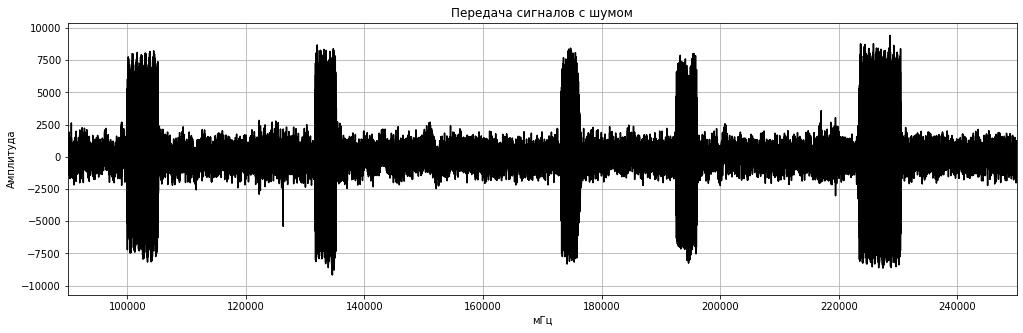

In [71]:
import numpy as np
import scipy.io.wavfile as wav
import math as m


class Sound:
    def __init__(self, name_of_wav_file):
        rate, data = wav.read(name_of_wav_file)
        self.y = np.array(data)
        self.x = np.arange(len(data)) / float(rate)
        self.rate = rate
        
name_of_wav_file = "not-perfect-example.wav"
sound_trend = Sound(name_of_wav_file)

# Гармоничекое процесс
c = 1  # Константа

x = sound_trend.x
y = sound_trend.y * c
rate = sound_trend.rate
print(y)
n = len(x)
flag_checking_display_n = 1
plt.figure(figsize=(17, 5))
plt.title("Передача сигналов c шумом")
plt.xlabel('мГц')
plt.ylabel('Амплитуда')
plt.xlim(90000,250000)
plt.grid(True)

plt.plot(y,color='black')

[128 129 130 ... 128 128 128]


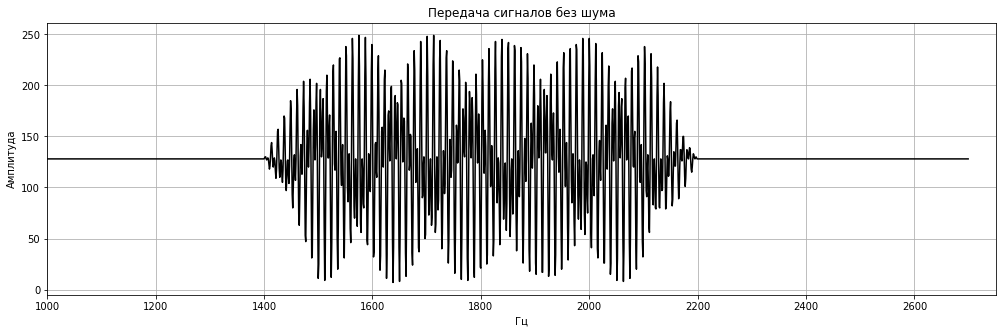

In [87]:
import numpy as np
import scipy.io.wavfile as wav
import math as m


class Sound:
    def __init__(self, name_of_wav_file):
        rate, data = wav.read(name_of_wav_file)
        self.y = np.array(data)
        self.x = np.arange(len(data)) / float(rate)
        self.rate = rate
        
name_of_wav_file = "perfect-example.wav"
sound_trend = Sound(name_of_wav_file)

# Гармоничекое процесс
c = 1  # Константа

x = sound_trend.x
y = sound_trend.y * c
rate = sound_trend.rate
print(y)
n = len(x)
flag_checking_display_n = 1
plt.figure(figsize=(17, 5))
plt.title("Передача сигналов без шума")
plt.xlabel('Гц')
plt.ylabel('Амплитуда')
plt.xlim(1000,2750)
plt.grid(True)
y = y[1800:4500]
plt.plot(y,color='black')

In [29]:

print(y)
funcFourier = amplitude_furie(y)

[ 98  69  76 ... 224 168 119]


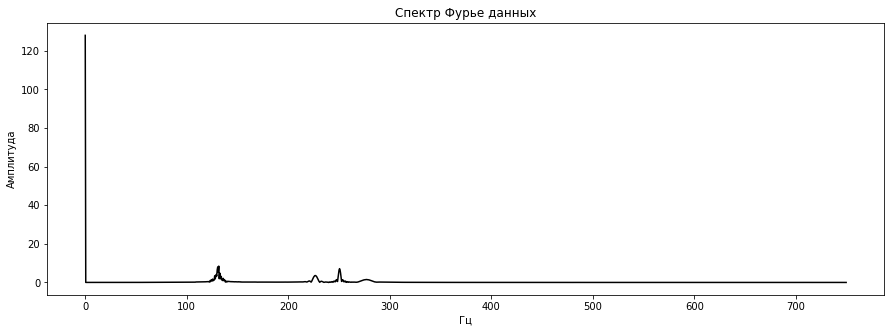

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(inherz(funcFourier[0]),funcFourier[1],color='black')

plt.xlabel('Гц')
plt.ylabel('Амплитуда')
plt.title("Спектр Фурье данных")
#$plt.xlim(0, 1.0)
plt.show()

In [48]:
import random as r
y = y 

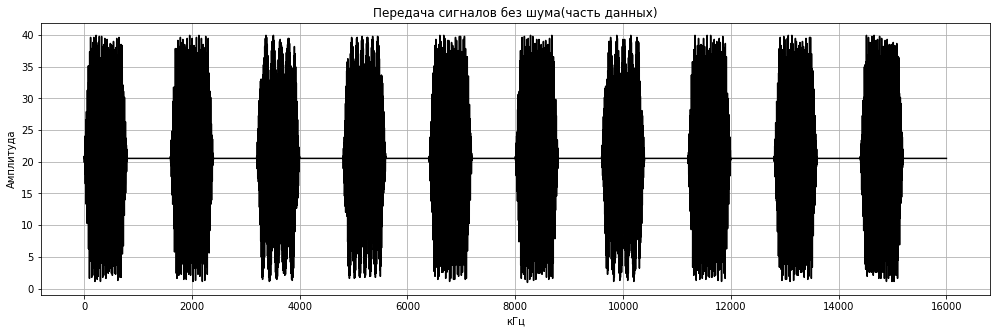

In [49]:
plt.figure(figsize=(17, 5))
plt.title("Передача сигналов без шума(часть данных)")
plt.xlabel('кГц')
plt.ylabel('Амплитуда')

plt.grid(True)

plt.plot(y,color='black')

In [8]:
# Осцилограмма буквы О
funcLetter = Function()
funcLetter.wave_func('буква А.wav', 'rb')
rate = 22050 # граничная частота
dt = 1 / rate # шаг дискретизации

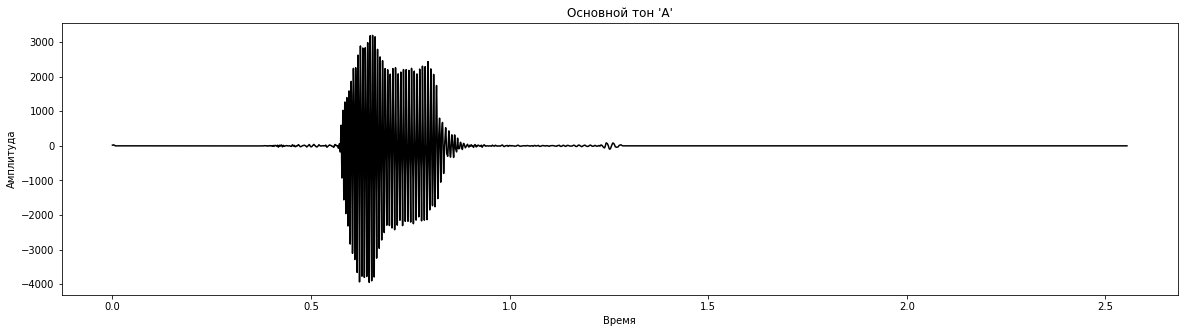

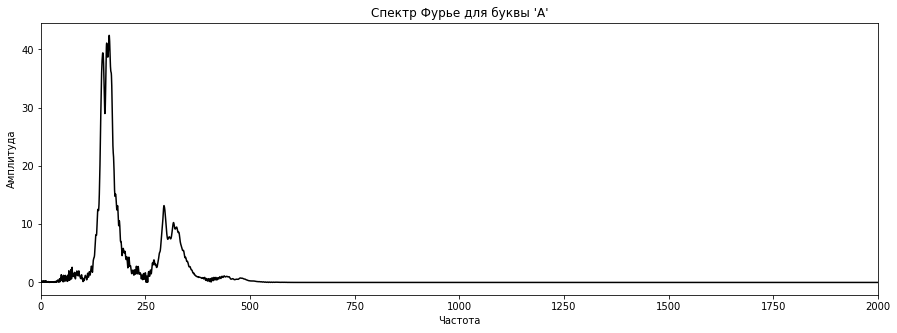

In [9]:
start = 0
step = 1
m = 128

# Веса для LPF фильтра
lpw = Function(start, 2 * m + 1, step)
lpw.lpf(300 * dt, dt, m) # граница 250 Гц

# Выделение основного тона в букве А
funcConv = Function(start, funcLetter.length * dt, dt)
funcConv.convolution_func(funcLetter, lpw)
plt.figure(figsize=(20, 5))
funcConv.display('Основной тон \'А\'', 'Время', 'Амплитуда')

# Спектр Фурье для основного тона буквы О
funcFourier = Function(0, funcConv.length, 1)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Спектр Фурье для буквы \'А\'', 'Частота', 'Амплитуда')
plt.xlim(0, 2000)

# Запись основного тона буквы О в файл
funcConv.amplify_wave(2,funcConv, 'основной тон буква А.wav', 22050) # без усиления

(200.0, 1000.0)

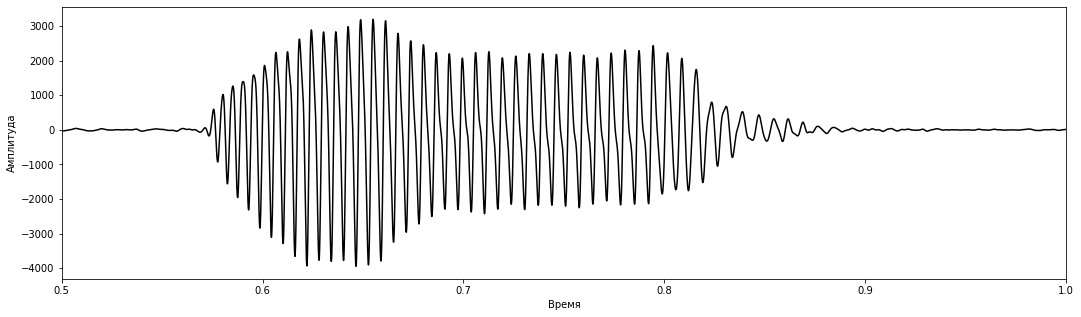

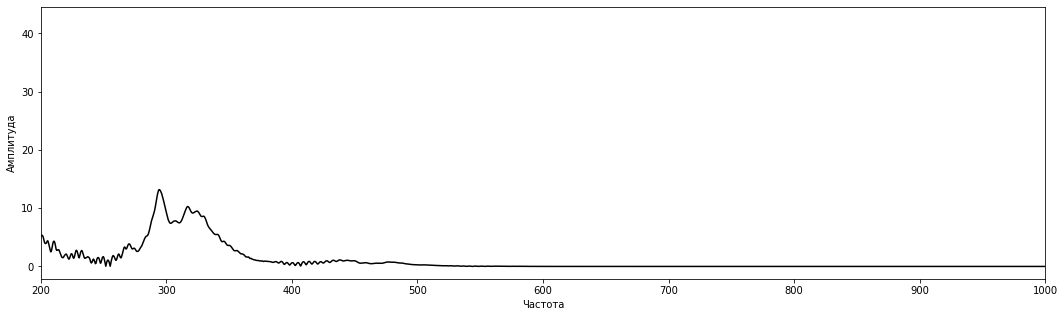

In [11]:
plt.figure(figsize=(18, 5))
funcConv.display('', 'Время', 'Амплитуда')
plt.xlim(0.5, 1.0)
plt.figure(figsize=(18, 5))
funcFourier.display('', 'Частота', 'Амплитуда')
plt.xlim(200, 1000)

error: short format requires (-32768) <= number <= 32767

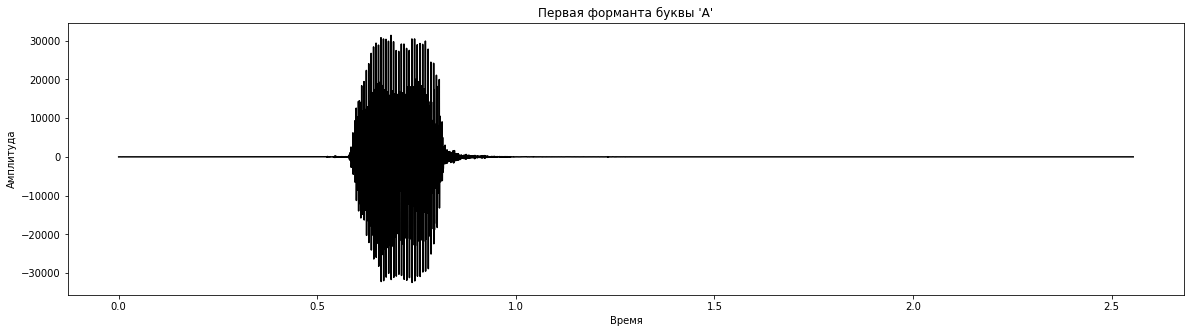

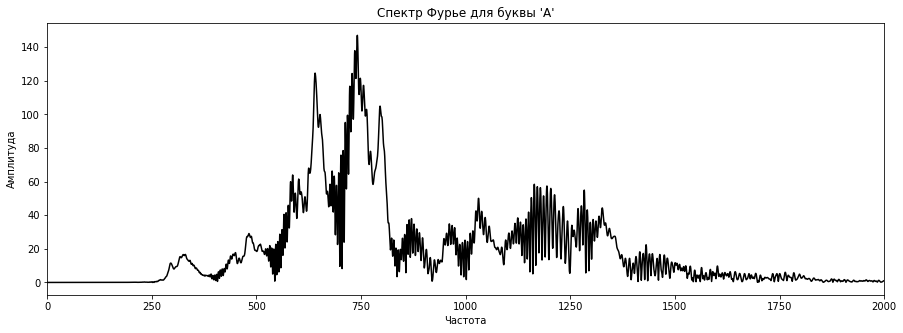

In [12]:
start = 0
step = 1
m = 256

# Веса для BPW фильтра
bpw = Function(start, 2 * m + 1, step)
bpw.bpf(300 * dt, 2300 * dt, dt, m)

# Выделение первой форманты в букве И
funcConv = Function(start, funcLetter.length * dt, dt)
funcConv.convolution_func(funcLetter, bpw)
plt.figure(figsize=(20, 5))
funcConv.display('Первая форманта буквы \'А\'', 'Время', 'Амплитуда')

# Спектр Фурье для первой форманты буквы И
funcFourier = Function(0, funcConv.length, 1)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Спектр Фурье для буквы \'А\'', 'Частота', 'Амплитуда')
plt.xlim(0, 2000)

# Запись первой форманты буквы И в файл
funcConv.amplify_wave(2, funcConv, 'форманты буквы А.wav', 22050) # усиление в 2 раза

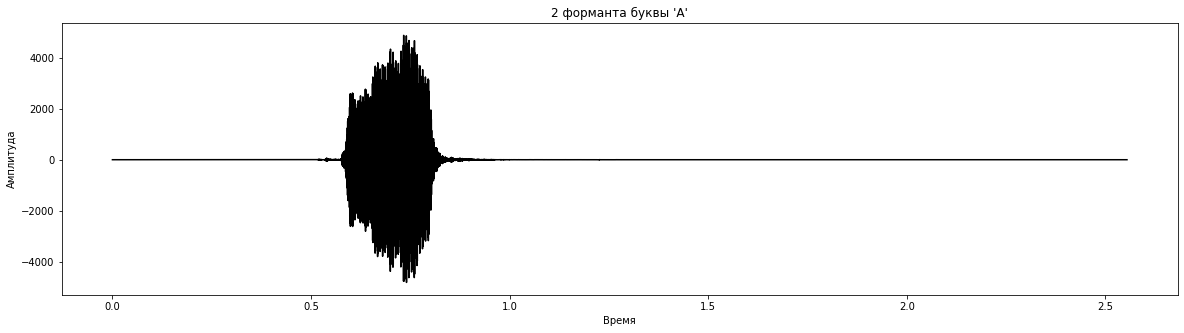

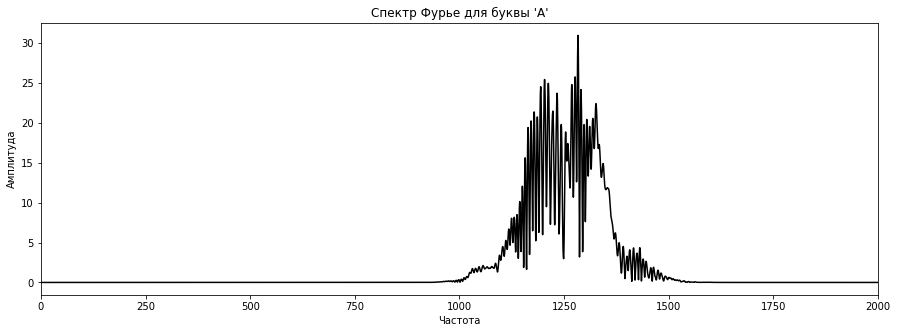

In [46]:
start = 0
step = 1
m = 128

# Веса для BPW фильтра
bpw = Function(start, 2 * m + 1, step)
bpw.bpf(1200 * dt,1350 * dt, dt, m)

# Выделение второй форманты в букве И
funcConv = Function(start, funcLetter.length * dt, dt)
funcConv.convolution_func(funcLetter, bpw)
plt.figure(figsize=(20, 5))
funcConv.display('2 форманта буквы \'А\'', 'Время', 'Амплитуда')

# Спектр Фурье для второй форманты буквы И
funcFourier = Function(0, funcConv.length, 1)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Спектр Фурье для буквы \'А\'', 'Частота', 'Амплитуда')
plt.xlim(0, 2000)

# Запись второй форманты буквы И в файл
funcConv.amplify_wave(3, funcConv, '2 форманта буква А.wav', 22050) # усиление в 3 раза

(900.0, 1600.0)

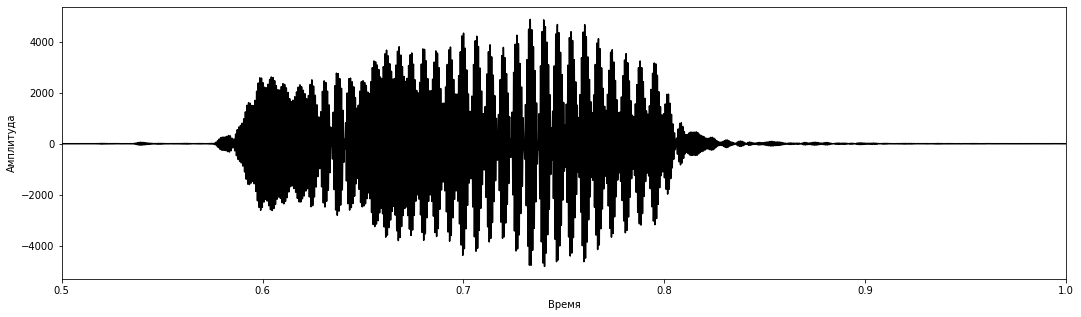

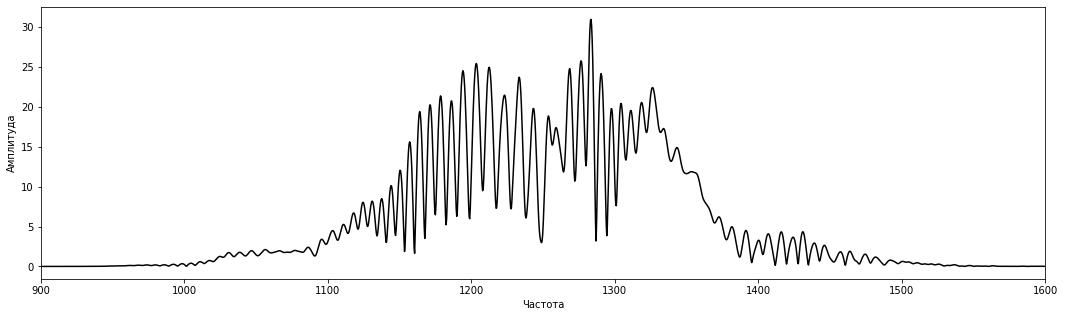

In [52]:
plt.figure(figsize=(18, 5))
funcConv.display('', 'Время', 'Амплитуда')
plt.xlim(0.5, 1.0)
plt.figure(figsize=(18, 5))
funcFourier.display('', 'Частота', 'Амплитуда')
plt.xlim(900, 1600)

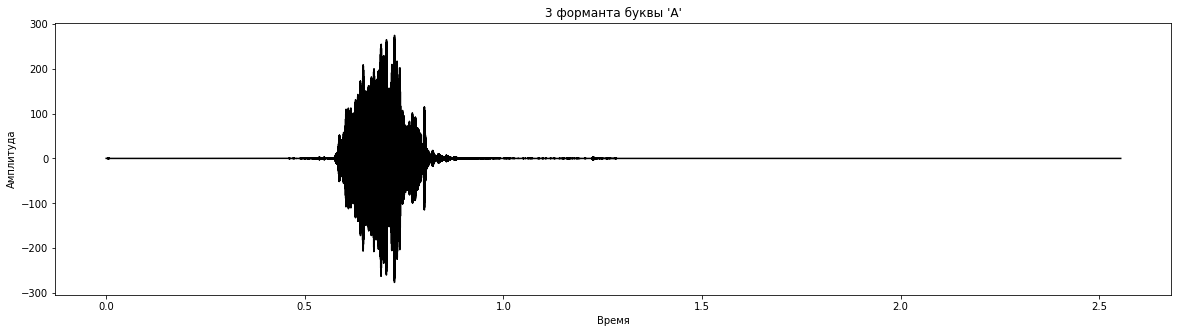

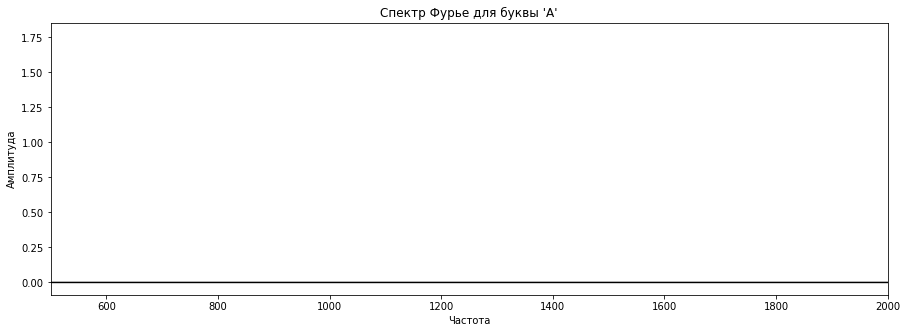

In [53]:
start = 0
step = 1
m = 128

# Веса для BPW фильтра
bpw = Function(start, 2 * m + 1, step)
bpw.bpf(2500 * dt, 2600 * dt, dt, m)

# Выделение третьей форманты в букве И
funcConv = Function(start, funcLetter.length * dt, dt)
funcConv.convolution_func(funcLetter, bpw)
plt.figure(figsize=(20, 5))
funcConv.display('3 форманта буквы \'А\'', 'Время', 'Амплитуда')

# Спектр Фурье для третьей форманты буквы И
funcFourier = Function(0, funcConv.length, 1)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Спектр Фурье для буквы \'А\'', 'Частота', 'Амплитуда')
plt.xlim(500, 2000)

# Запись третьей форманты буквы И в файл
funcConv.amplify_wave(17, funcConv, '3 форманта.wav', 22050) # усиление в 17 раз

(3000.0, 4000.0)

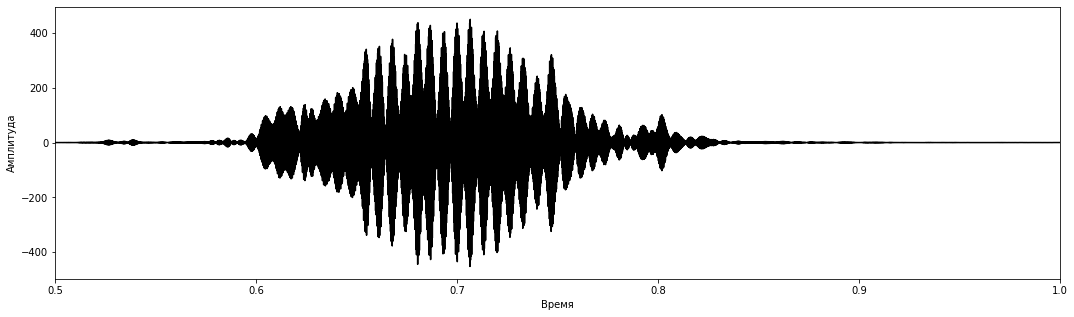

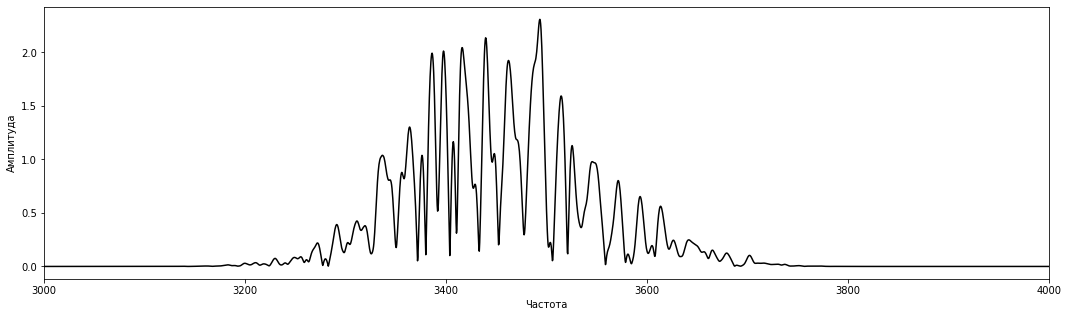

In [18]:
plt.figure(figsize=(18, 5))
funcConv.display('', 'Время', 'Амплитуда')
plt.xlim(0.5, 1.0)
plt.figure(figsize=(18, 5))
funcFourier.display('', 'Частота', 'Амплитуда')
plt.xlim(3000, 4000)

In [ ]:
start = 0
step = 1
m = 128

# Веса для BPW фильтра
bpw = Function(start, 2 * m + 1, step)
bpw.bpf(3400 * dt, 3500 * dt, dt, m)

# Выделение четвёртой форманты в букве И
funcConv = Function(start, funcLetter.length * dt, dt)
funcConv.convolution_func(funcLetter, bpw)
plt.figure(figsize=(20, 5))
funcConv.display('4 форманта буквы \'А\'', 'Время', 'Амплитуда')

# Спектр Фурье для четвёртой форманты буквы И
funcFourier = Function(0, funcConv.length, 1)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Спектр Фурье для буквы \'А\'', 'Частота', 'Амплитуда')
plt.xlim(1250, 2500)

# Запись четвёртой форманты буквы О в файл
funcConv.amplify_wave(32, funcConv, '4 форманта буква а.wav', 22050) # усиление в 32 раза

(3000.0, 4000.0)

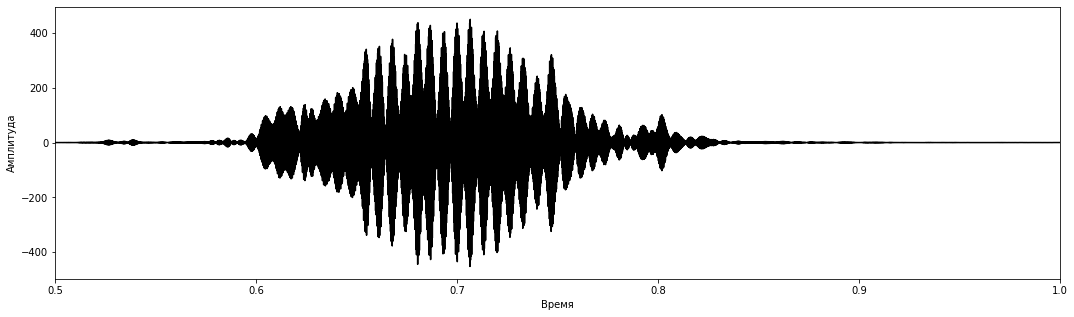

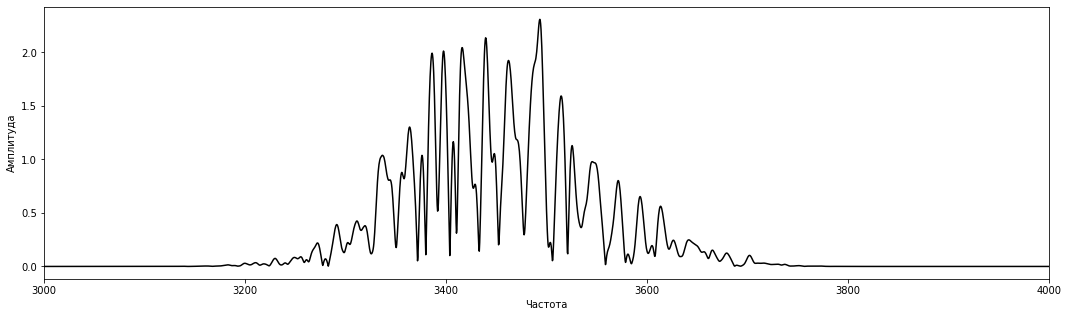

In [22]:
plt.figure(figsize=(18, 5))
funcConv.display('', 'Время', 'Амплитуда')
plt.xlim(0.5, 1.0)
plt.figure(figsize=(18, 5))
funcFourier.display('', 'Частота', 'Амплитуда')
plt.xlim(3000, 4000)